In [33]:
import pandas as pd


# Load data variables

In [34]:
# Load true data
true_data = pd.read_csv("./../processed_VideoCommentsThreatCorpus.csv")
true_data['flags'] = true_data['flags'].apply(lambda x: int(eval(x)[0]))
true_data.rename(columns={"id": "document_id", "flags": "true_label"}, inplace=True)

### Neighbors
neighbors_mistral=pd.read_csv("./../test_results_from_idun/neighbors/neighbor_mistral_final.csv")
neighbors_nemo = pd.read_csv("./../test_results_from_idun/neighbors/neighbor_mistral-nemo_final.csv")
neighbors_small = pd.read_csv("./../test_results_from_idun/neighbors/neighbor-mistral-small-final.csv")
neighbors_q8 = pd.read_csv("./../test_results_from_idun/neighbors/neighbor_qwen3-8-final.csv")
neighbors_q14 = pd.read_csv("./../test_results_from_idun/neighbors/neighbor_qwen3-14-final.csv")
# neighbors_gemma = pd.read_csv("./../test_results_from_idun/neighbors/neighbor-gemma312b-final.csv")

agents_mistral = pd.read_csv("./../test_results_from_idun/no_context/no_context_mistral_final.csv")
agents_nemo = pd.read_csv("./../test_results_from_idun/no_context/no_context_mistral-nemo_final.csv")
agents_small = pd.read_csv("./../test_results_from_idun/no_context/no_context_mistral-small_final.csv")
agents_q8 = pd.read_csv("./../test_results_from_idun/no_context/no_context_qwen3-8-final.csv")
agents_q14 = pd.read_csv("./../test_results_from_idun/no_context/no_context_qwen14b-final.csv")
# agents_gemma = pd.read_csv("./../test_results_from_idun/no_context/no_context-gemma312b-final.csv")

solo_mistral = pd.read_csv("./../test_results_from_idun/solo/solomistral_final.csv")
solo_nemo = pd.read_csv("./../test_results_from_idun/solo/solomistral-nemo_final.csv")
solo_small = pd.read_csv("./../test_results_from_idun/solo/solomistral-small_final.csv")
solo_q8 = pd.read_csv("./../test_results_from_idun/solo/soloqwen3-8b_final.csv")
solo_q14 = pd.read_csv("./../test_results_from_idun/solo/soloqwen3-14b_final.csv")

context_mistral = pd.read_csv("./../test_results_from_idun/context/context_analysis_mistral_final.csv")
context_nemo = pd.read_csv("./../test_results_from_idun/context/context_analysis_mistral-nemo_final.csv")
context_small = pd.read_csv("./../test_results_from_idun/context/context_analysis_mistral-small_final.csv")
context_q8 = pd.read_csv("./../test_results_from_idun/context/context_analysis_qwen3-8-final.csv")
context_q14 = pd.read_csv("./../test_results_from_idun/context/context_analysis_qwen3-14-final.csv")


model_dfs_neighbors = [neighbors_mistral, neighbors_nemo,
             neighbors_q8, neighbors_q14, neighbors_small]
model_dfs_agents = [agents_mistral, agents_nemo,
             agents_q8, agents_q14, agents_small]
model_dfs_solo = [solo_mistral, solo_nemo,
             solo_q8, solo_q14, solo_small]
model_dfs_context = [context_mistral, context_nemo, context_q8, context_q14, context_small]

## Many variations given by the models :)
intent_mapping = { "no intent of violence": 0, "no intent": 0, "low intent of violence": 1, "low intent": 1, "moderate intent of violence": 2, "moderate intent": 2,"high intent of violence": 3,"high intent": 3}
call_to_action_mapping = { 'no call to action': 0,'low call to action': 1,
    'low call-to-action': 1, 'high call to action': 3, 'moderate call-to-action': 2,' no call-to-action': 0,' no call to action': 0,'low call-to action': 1, 'no call-to-action': 0, 'high call-to-action': 3, ' no call-to action': 0, 'moderate call to action': 2,
    'low call-to-action': 1, ' high call to action': 3, 'moderate call-to action': 2,'no call-to action': 0,'moderate call-to_action': 2,'moderate call': 2,
    'low call': 1,'low call to action': 1,' high call-to-action': 3,'high call': 3,'no call': 0,'low': 1,'no': 0,'low call-to_action': 1
}
def adjust_labels(pred_df):
    pred_df['violence_label'] = pred_df['violence_label'].apply(lambda x: 0 if x in [0, 1] else 1 if x == 2 else -1)
    # Convert strings to lowercase before mapping
    pred_df["intent_numeric"] = pred_df["intent_label"].str.lower().replace("-", "").replace("_", "").map(intent_mapping)
    pred_df["call_to_action_numeric"] = pred_df["call_to_action"].str.lower().replace("-", "").replace("_", "").map(call_to_action_mapping)
    return pred_df
def adjust_labels_solo(pred_df):
    pred_df['violence_label'] = pred_df['violence_label'].apply(lambda x: 0 if x in [0, 1] else 1 if x == 2 else -1)
    return pred_df

# Apply to all and label models
model_names = ["mistral", "nemo", "qwen_8b", "qwen_14b",  "small"]
for i in range(len(model_dfs_neighbors)):
    model_dfs_neighbors[i] = adjust_labels(model_dfs_neighbors[i])
    model_dfs_neighbors[i]["model"] = model_names[i]
    model_dfs_neighbors[i]["pipe"] = "neighbors"

for i in range(len(model_dfs_agents)):
    model_dfs_agents[i] = adjust_labels(model_dfs_agents[i])
    model_dfs_agents[i]["model"] = model_names[i]
    model_dfs_agents[i]["pipe"] = "agents"
    
for i in range(len(model_dfs_context)):
    model_dfs_context[i] = adjust_labels(model_dfs_context[i])
    model_dfs_context[i]["model"] = model_names[i]
    model_dfs_context[i]["pipe"] = "context"

for i in range(len(model_dfs_solo)):
    model_dfs_solo[i] = adjust_labels_solo(model_dfs_solo[i])
    model_dfs_solo[i]["model"] = model_names[i]
    model_dfs_solo[i]["pipe"] = "solo"


combined_for_all = pd.concat(model_dfs_neighbors + model_dfs_agents + model_dfs_solo + model_dfs_context, ignore_index=True)
combined_agents_only = pd.concat(model_dfs_agents + model_dfs_neighbors + model_dfs_context, ignore_index=True)

#Add the true labels
combined_agents_only = combined_agents_only.merge(
    true_data[["document_id", "true_label", "content"]],
    on="document_id",
    how="left"
)

combined_for_all = combined_for_all.merge(
    true_data[["document_id", "true_label", "content"]],
    on="document_id",
    how="left"
)

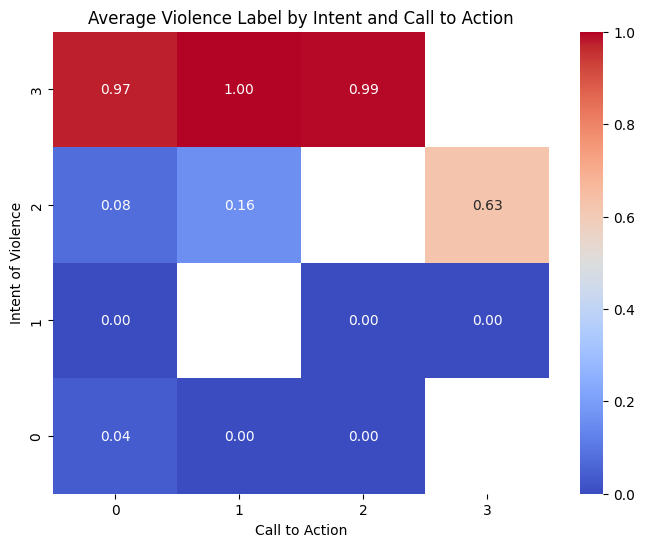

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by intent and call_to_action
heatmap_data = context_small.groupby(['intent_numeric', 'call_to_action_numeric'])['violence_label'].mean().unstack()

# Plot heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
ax.set_title('Average Violence Label by Intent and Call to Action')
ax.set_xlabel('Call to Action')
ax.set_ylabel('Intent of Violence')
ax.invert_yaxis()


plt.show()

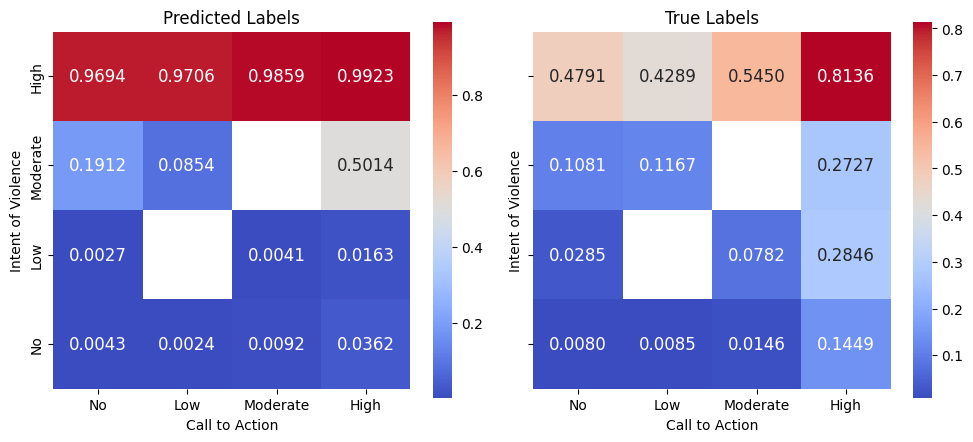

In [36]:

import seaborn as sns
import matplotlib.pyplot as plt

# Group by intent and call-to-action numeric values
heatmap_data_predicted = combined_agents_only.groupby(['intent_numeric', 'call_to_action_numeric'])['violence_label'].mean().unstack()
heatmap_data_true = combined_agents_only.groupby(['intent_numeric', 'call_to_action_numeric'])['true_label'].mean().unstack()


labels = ["No", "Low", "Moderate", "High"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Heatmap: Predicted
sns.heatmap(
    heatmap_data_predicted,
    annot=True,
    cmap='coolwarm',
    fmt=".4f",
    ax=axes[0],
    square=True,
    cbar_kws={"shrink": 0.8},
    annot_kws={"fontsize": 12}  # Larger font size in cells
)
axes[0].set_title('Predicted Labels')
axes[0].set_xlabel('Call to Action')
axes[0].set_ylabel('Intent of Violence')
axes[0].invert_yaxis()
axes[0].set_xticklabels(labels)
axes[0].set_yticklabels(labels)

# Heatmap: True
sns.heatmap(
    heatmap_data_true,
    annot=True,
    cmap='coolwarm',
    fmt=".4f",
    ax=axes[1],
    square=True,
    cbar_kws={"shrink": 0.8},
    annot_kws={"fontsize": 12}
)
axes[1].set_title('True Labels')
axes[1].set_xlabel('Call to Action')
axes[1].set_ylabel('Intent of Violence')
axes[1].invert_yaxis()
axes[1].set_xticklabels(labels)
axes[1].set_yticklabels(labels)

plt.tight_layout()
plt.show()

In [37]:


# Decode flagged_issues into a proper list
combined_for_all["flagged_issues"] = combined_for_all["flagged_issues"].apply(eval)

# Create binary flags
combined_for_all["has_flag"] = combined_for_all["flagged_issues"].apply(lambda x: len(x) > 0)

# Add correctness column
combined_for_all["is_correct"] = combined_for_all["violence_label"] == combined_for_all["true_label"]


# Decode flagged_issues into a proper list
combined_agents_only["flagged_issues"] = combined_agents_only["flagged_issues"].apply(eval)

# Create binary flags
combined_agents_only["has_flag"] = combined_agents_only["flagged_issues"].apply(lambda x: len(x) > 0)

# Add correctness column
combined_agents_only["is_correct"] = combined_agents_only["violence_label"] == combined_agents_only["true_label"]

In [38]:
flagged_perf = combined_for_all.groupby("has_flag")["is_correct"].mean()
print("Accuracy With and Without Flags:")
print(flagged_perf)


Accuracy With and Without Flags:
has_flag
False    0.825801
True     0.831445
Name: is_correct, dtype: float64


In [39]:
from collections import defaultdict

# Initialize counters
flag_stats = defaultdict(lambda: {"count": 0, "correct": 0})

# Count accuracy for each flag type
for _, row in combined_for_all.iterrows():
    for flag in row["flagged_issues"]:
        flag_stats[flag]["count"] += 1
        if row["is_correct"]:
            flag_stats[flag]["correct"] += 1

# Convert to DataFrame
flag_df = pd.DataFrame({
    flag: {
        "flag_count": stats["count"],
        "accuracy_when_flagged": stats["correct"] / stats["count"] if stats["count"] else 0
    }
    for flag, stats in flag_stats.items()
}).T

print(flag_df)



   flag_count  accuracy_when_flagged
0     62662.0               0.828365
1     24677.0               0.850630
2      1116.0               0.849462
4       170.0               0.788235
3      1168.0               0.581336


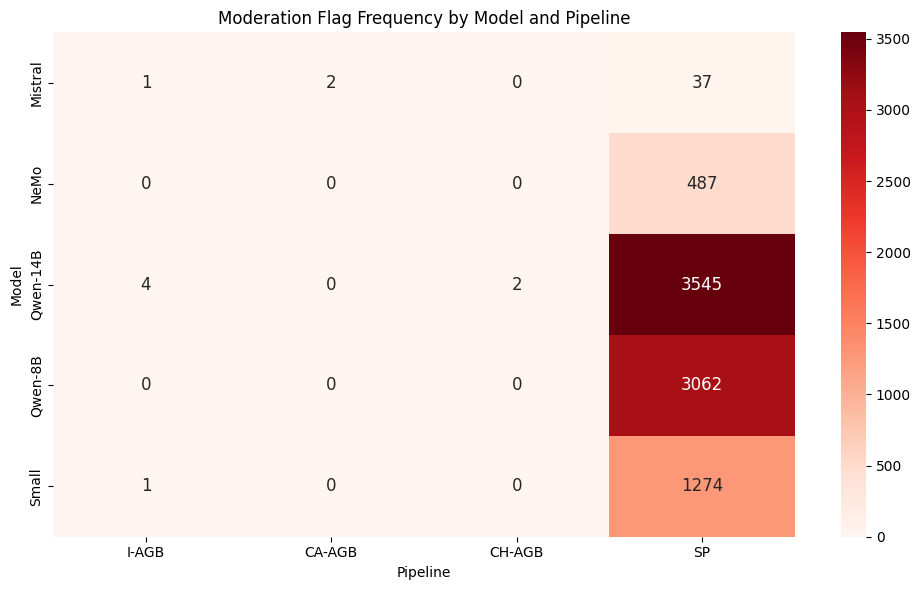

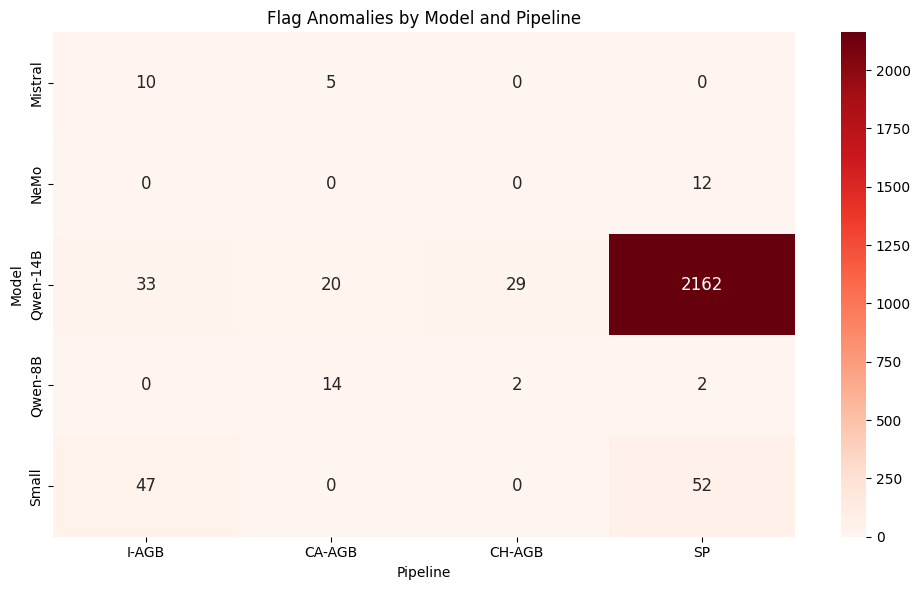

In [40]:



# moderations = combined_for_all[combined_for_all["flagged_issues"].apply(lambda flags: 3 in flags)]


# # Create a frequency table of model-pipeline combinations
# model_pipe_matrix = moderations.groupby(['model', 'pipe']).size().unstack(fill_value=0)

# # Plot as heatmap
# plt.figure(figsize=(10, 6))
# sns.heatmap(model_pipe_matrix, annot=True, cmap="Reds", fmt="d")
# plt.title("Moderation Flag (3) Frequency by Model and Pipeline")
# plt.xlabel("Pipeline")
# plt.ylabel("Model")
# plt.tight_layout()
# plt.show()

def is_moderation_flag(row):
    if row["pipe"] == "solo":
        return 1 in row["flagged_issues"]
    else:
        return 3 in row["flagged_issues"]

# Apply the filter
moderations = combined_for_all[combined_for_all.apply(is_moderation_flag, axis=1)]

# Create a frequency table of model-pipeline combinations
model_pipe_matrix = moderations.groupby(['model', 'pipe']).size().unstack(fill_value=0)
anomalies = combined_for_all[
    combined_for_all.apply(
        lambda row: 
        any(f not in ["",0, 1] for f in row["flagged_issues"])
        if row["pipe"] == "solo"
        else any(f not in ["",0, 1, 2, 3] for f in row["flagged_issues"]),
        axis=1
    )
]
# Create a frequency table of model-pipeline combinations
anomaly_matrix = anomalies.groupby(['model', 'pipe']).size().unstack(fill_value=0)

# Pretty label maps
model_name_map = {
    "mistral": "Mistral",
    "nemo": "NeMo",
    "small": "Small",
    "qwen_8b": "Qwen-8B",
    "qwen_14b": "Qwen-14B",
    "gemma": "Gemma"
}
pipe_name_map = {
    "agents": "I-AGB",
    "context": "CA-AGB",
    "neighbors": "CH-AGB",
    "solo": "SP"
}

# Apply renaming
mod_matrix = model_pipe_matrix.rename(index=model_name_map, columns=pipe_name_map)
anom_matrix = anomaly_matrix.rename(index=model_name_map, columns=pipe_name_map)

# --- First Heatmap: Moderation Flag Frequency ---
plt.figure(figsize=(10, 6))
sns.heatmap(
    mod_matrix,
    annot=True,
    fmt="d",
    cmap="Reds",
    annot_kws={"fontsize": 12}
)
plt.title("Moderation Flag Frequency by Model and Pipeline")
plt.xlabel("Pipeline")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

# --- Second Heatmap: Anomaly Frequency ---
plt.figure(figsize=(10, 6))
sns.heatmap(
    anom_matrix,
    annot=True,
    fmt="d",
    cmap="Reds",
    annot_kws={"fontsize": 12}
)
plt.title("Flag Anomalies by Model and Pipeline")
plt.xlabel("Pipeline")
plt.ylabel("Model")
plt.tight_layout()
plt.show()



      model  total_instances  accuracy  true_positives  false_positives  \
4     small            38520  0.880426            2596             2153   
2  qwen_14b            38520  0.823416            3501             5254   
1      nemo            38520  0.822222            3451             5250   
3   qwen_8b            38520  0.817913            3183             5148   
0   mistral            38520  0.798183            3179             5904   

   false_negatives  precision    recall  f1_score  
4             2453   0.546641  0.514161  0.529904  
2             1548   0.399886  0.693405  0.507244  
1             1598   0.396621  0.683502  0.501964  
3             1866   0.382067  0.630422  0.475785  
0             1870   0.349994  0.629630  0.449901  


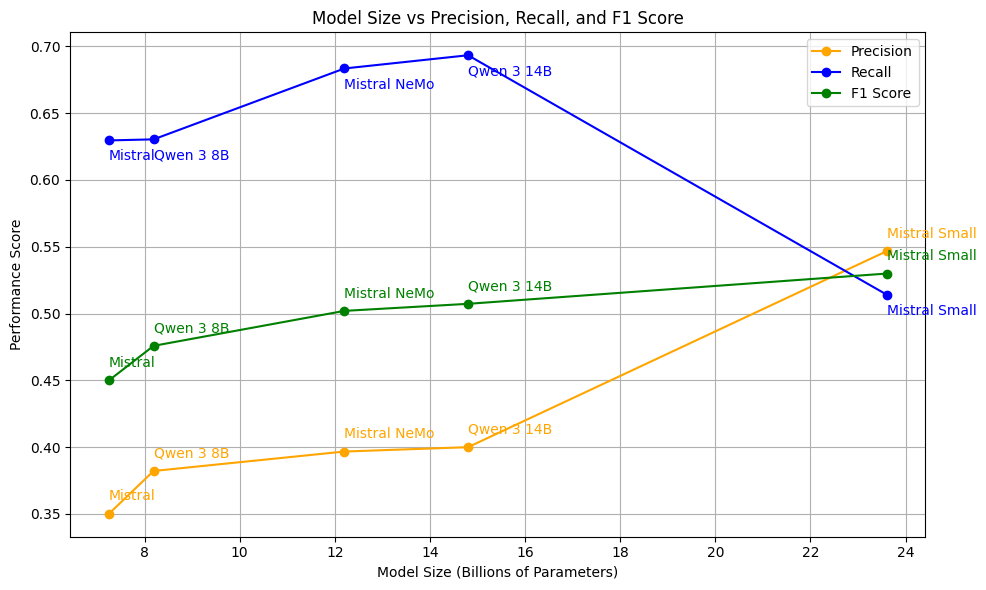

In [41]:
# Group by model only (across all pipelines)
model_performance = (
    combined_for_all
    .groupby("model")
    .agg(
        total_instances=("violence_label", "count"),
        accuracy=("is_correct", "mean"),
        true_positives=("violence_label", lambda x: ((x == 1) & (combined_for_all.loc[x.index, "true_label"] == 1)).sum()),
        false_positives=("violence_label", lambda x: ((x == 1) & (combined_for_all.loc[x.index, "true_label"] == 0)).sum()),
        false_negatives=("violence_label", lambda x: ((x == 0) & (combined_for_all.loc[x.index, "true_label"] == 1)).sum())
    )
    .reset_index()
)

# Compute precision, recall, F1
model_performance["precision"] = model_performance["true_positives"] / (model_performance["true_positives"] + model_performance["false_positives"])
model_performance["recall"] = model_performance["true_positives"] / (model_performance["true_positives"] + model_performance["false_negatives"])
model_performance["f1_score"] = 2 * (model_performance["precision"] * model_performance["recall"]) / (model_performance["precision"] + model_performance["recall"])

# Replace NaNs with 0
model_performance = model_performance.fillna(0)

# Display sorted by F1-score
print(model_performance.sort_values("f1_score", ascending=False))

import matplotlib.pyplot as plt

# Define model sizes (in billions of parameters)
model_sizes = {
    "mistral": 7.25,
    "nemo": 12.2,
    "small": 23.6,
    "qwen_8b": 8.19,
    "qwen_14b": 14.8,
    "gemma": 12.2  # Add only if used
}

# Prettify model names
pretty_names = {
    "mistral": "Mistral",
    "nemo": "Mistral NeMo",
    "small": "Mistral Small",
    "qwen_8b": "Qwen 3 8B",
    "qwen_14b": "Qwen 3 14B",
    "gemma": "Gemma 3 12B"
}

# Add to DataFrame
model_performance["size"] = model_performance["model"].map(model_sizes)
model_performance["pretty_name"] = model_performance["model"].map(pretty_names)
model_performance = model_performance.sort_values("size")

# Plot setup
plt.figure(figsize=(10, 6))

# Plot each score
plt.plot(model_performance["size"], model_performance["precision"], marker='o', label="Precision", color="orange")
plt.plot(model_performance["size"], model_performance["recall"], marker='o', label="Recall", color="blue")
plt.plot(model_performance["size"], model_performance["f1_score"], marker='o', label="F1 Score", color="green")

# Annotate with adjusted vertical positions
for _, row in model_performance.iterrows():
    plt.text(row["size"], row["precision"] + 0.01, row["pretty_name"], fontsize=10, color="orange")
    plt.text(row["size"], row["recall"] - 0.015, row["pretty_name"], fontsize=10, color="blue")
    plt.text(row["size"], row["f1_score"] + 0.01, row["pretty_name"], fontsize=10, color="green")

# Labels and styling
plt.xlabel("Model Size (Billions of Parameters)")
plt.ylabel("Performance Score")
plt.title("Model Size vs Precision, Recall, and F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
# Group by pipeline only
pipeline_performance = (
    combined_for_all
    .groupby("pipe")
    .agg(
        total_instances=("violence_label", "count"),
        accuracy=("is_correct", "mean"),
        true_positives=("violence_label", lambda x: ((x == 1) & (combined_for_all.loc[x.index, "true_label"] == 1)).sum()),
        false_positives=("violence_label", lambda x: ((x == 1) & (combined_for_all.loc[x.index, "true_label"] == 0)).sum()),
        false_negatives=("violence_label", lambda x: ((x == 0) & (combined_for_all.loc[x.index, "true_label"] == 1)).sum())
    )
    .reset_index()
)

# Compute precision, recall, F1
pipeline_performance["precision"] = pipeline_performance["true_positives"] / (pipeline_performance["true_positives"] + pipeline_performance["false_positives"])
pipeline_performance["recall"] = pipeline_performance["true_positives"] / (pipeline_performance["true_positives"] + pipeline_performance["false_negatives"])
pipeline_performance["f1_score"] = 2 * (pipeline_performance["precision"] * pipeline_performance["recall"]) / (pipeline_performance["precision"] + pipeline_performance["recall"])

# Clean up
pipeline_performance = pipeline_performance.fillna(0)

# Show table
print(pipeline_performance.sort_values("f1_score", ascending=False))

        pipe  total_instances  accuracy  true_positives  false_positives  \
0     agents            48150  0.882555            4581             3936   
2  neighbors            48150  0.862181            4786             5122   
1    context            48150  0.845192            5043             6197   
3       solo            48150  0.723801            1500             8454   

   false_negatives  precision    recall  f1_score  
0             1719   0.537865  0.727143  0.618344  
2             1514   0.483044  0.759683  0.590573  
1             1257   0.448665  0.800476  0.575029  
3             4845   0.150693  0.236407  0.184060  


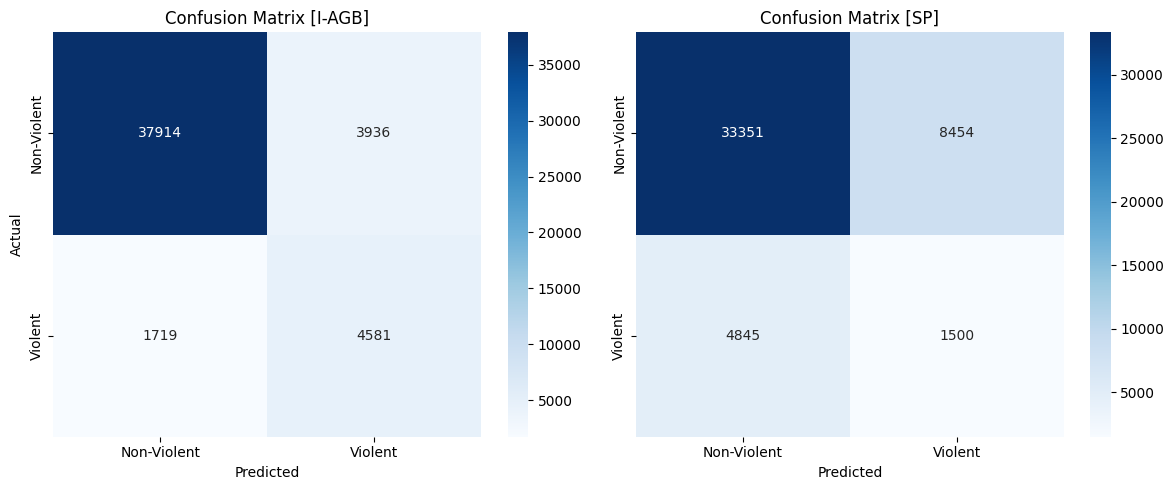

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Filter by pipeline
agents = combined_for_all[combined_for_all["pipe"] == "agents"]
solo = combined_for_all[combined_for_all["pipe"] == "solo"]

# Compute confusion matrices
cm_agents = confusion_matrix(agents["true_label"], agents["violence_label"])
cm_solo = confusion_matrix(solo["true_label"], solo["violence_label"])

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Agents
sns.heatmap(cm_agents, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Violent', 'Violent'],
            yticklabels=['Non-Violent', 'Violent'],
            ax=axes[0])
axes[0].set_title('Confusion Matrix [I-AGB]')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Solo
sns.heatmap(cm_solo, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Violent', 'Violent'],
            yticklabels=['Non-Violent', 'Violent'],
            ax=axes[1])
axes[1].set_title('Confusion Matrix [SP]')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


In [44]:
# Group by model only (across all pipelines)
model_performance = (
    combined_agents_only
    .groupby("model")
    .agg(
        total_instances=("violence_label", "count"),
        accuracy=("is_correct", "mean"),
        true_positives=("violence_label", lambda x: ((x == 1) & (combined_agents_only.loc[x.index, "true_label"] == 1)).sum()),
        false_positives=("violence_label", lambda x: ((x == 1) & (combined_agents_only.loc[x.index, "true_label"] == 0)).sum()),
        false_negatives=("violence_label", lambda x: ((x == 0) & (combined_agents_only.loc[x.index, "true_label"] == 1)).sum())
    )
    .reset_index()
)

# Compute precision, recall, F1
model_performance["precision"] = model_performance["true_positives"] / (model_performance["true_positives"] + model_performance["false_positives"])
model_performance["recall"] = model_performance["true_positives"] / (model_performance["true_positives"] + model_performance["false_negatives"])
model_performance["f1_score"] = 2 * (model_performance["precision"] * model_performance["recall"]) / (model_performance["precision"] + model_performance["recall"])

# Replace NaNs with 0
model_performance = model_performance.fillna(0)

# Display sorted by F1-score
print(model_performance.sort_values("f1_score", ascending=False))

      model  total_instances  accuracy  true_positives  false_positives  \
4     small            28890  0.911042            2447             1237   
2  qwen_14b            28890  0.859467            3191             3471   
3   qwen_8b            28890  0.878989            2690             2406   
1      nemo            28890  0.839772            3236             4085   
0   mistral            28890  0.827276            2846             4056   

   false_negatives  precision    recall  f1_score  
4             1333   0.664224  0.647354  0.655681  
2              589   0.478985  0.844180  0.611186  
3             1090   0.527865  0.711640  0.606129  
1              544   0.442016  0.856085  0.583011  
0              934   0.412344  0.752910  0.532859  


In [45]:
solo_df = combined_for_all[combined_for_all["pipe"] == "solo"]
# Group by model only (across all pipelines)
model_performance = (
    solo_df
    .groupby("model")
    .agg(
        total_instances=("violence_label", "count"),
        accuracy=("is_correct", "mean"),
        true_positives=("violence_label", lambda x: ((x == 1) & (solo_df.loc[x.index, "true_label"] == 1)).sum()),
        false_positives=("violence_label", lambda x: ((x == 1) & (solo_df.loc[x.index, "true_label"] == 0)).sum()),
        false_negatives=("violence_label", lambda x: ((x == 0) & (solo_df.loc[x.index, "true_label"] == 1)).sum())
    )
    .reset_index()
)

# Compute precision, recall, F1
model_performance["precision"] = model_performance["true_positives"] / (model_performance["true_positives"] + model_performance["false_positives"])
model_performance["recall"] = model_performance["true_positives"] / (model_performance["true_positives"] + model_performance["false_negatives"])
model_performance["f1_score"] = 2 * (model_performance["precision"] * model_performance["recall"]) / (model_performance["precision"] + model_performance["recall"])

# Replace NaNs with 0
model_performance = model_performance.fillna(0)

# Display sorted by F1-score
print(model_performance.sort_values("f1_score", ascending=False))

      model  total_instances  accuracy  true_positives  false_positives  \
3   qwen_8b             9630  0.634683             493             2742   
0   mistral             9630  0.710903             333             1848   
2  qwen_14b             9630  0.715265             310             1783   
1      nemo             9630  0.769574             215             1165   
4     small             9630  0.788577             149              916   

   false_negatives  precision    recall  f1_score  
3              776   0.152396  0.388495  0.218917  
0              936   0.152682  0.262411  0.193043  
2              959   0.148113  0.244287  0.184414  
1             1054   0.155797  0.169425  0.162325  
4             1120   0.139906  0.117415  0.127678  


        pipe  total_instances  accuracy  true_positives  false_positives  \
0     agents            48150  0.882555            4581             3936   
2  neighbors            48150  0.862181            4786             5122   
1    context            48150  0.845192            5043             6197   

   false_negatives  precision    recall  f1_score  
0             1719   0.537865  0.727143  0.618344  
2             1514   0.483044  0.759683  0.590573  
1             1257   0.448665  0.800476  0.575029  


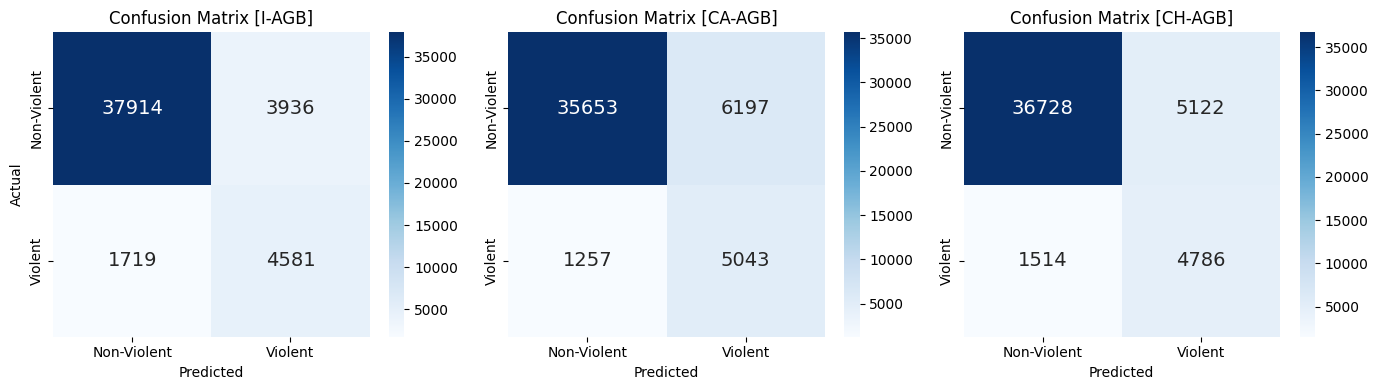

In [46]:
# Group by pipeline only
pipeline_performance = (
    combined_agents_only
    .groupby("pipe")
    .agg(
        total_instances=("violence_label", "count"),
        accuracy=("is_correct", "mean"),
        true_positives=("violence_label", lambda x: ((x == 1) & (combined_agents_only.loc[x.index, "true_label"] == 1)).sum()),
        false_positives=("violence_label", lambda x: ((x == 1) & (combined_agents_only.loc[x.index, "true_label"] == 0)).sum()),
        false_negatives=("violence_label", lambda x: ((x == 0) & (combined_agents_only.loc[x.index, "true_label"] == 1)).sum())
    )
    .reset_index()
)

# Compute precision, recall, F1
pipeline_performance["precision"] = pipeline_performance["true_positives"] / (pipeline_performance["true_positives"] + pipeline_performance["false_positives"])
pipeline_performance["recall"] = pipeline_performance["true_positives"] / (pipeline_performance["true_positives"] + pipeline_performance["false_negatives"])
pipeline_performance["f1_score"] = 2 * (pipeline_performance["precision"] * pipeline_performance["recall"]) / (pipeline_performance["precision"] + pipeline_performance["recall"])

# Clean up
pipeline_performance = pipeline_performance.fillna(0)

# Show table
print(pipeline_performance.sort_values("f1_score", ascending=False))

# Filter by pipeline
agents = combined_for_all[combined_for_all["pipe"] == "agents"]
context = combined_for_all[combined_for_all["pipe"] == "context"]
neighbors = combined_for_all[combined_for_all["pipe"] == "neighbors"]

# Compute confusion matrices
cm_agents = confusion_matrix(agents["true_label"], agents["violence_label"])
cm_context = confusion_matrix(context["true_label"], context["violence_label"])
cm_neighbors = confusion_matrix(neighbors["true_label"], neighbors["violence_label"])

# Plot side-by-side
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Agents
sns.heatmap(cm_agents, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Violent', 'Violent'],
            yticklabels=['Non-Violent', 'Violent'],
            annot_kws={"size": 14}, ax=axes[0])
axes[0].set_title('Confusion Matrix [I-AGB]')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Solo
sns.heatmap(cm_context, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Violent', 'Violent'],
            yticklabels=['Non-Violent', 'Violent'],
            annot_kws={"size": 14}, ax=axes[1])
axes[1].set_title('Confusion Matrix [CA-AGB]')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('')

sns.heatmap(cm_neighbors, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Violent', 'Violent'],
            yticklabels=['Non-Violent', 'Violent'],
          annot_kws={"size": 14}, ax=axes[2])
axes[2].set_title('Confusion Matrix [CH-AGB]')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()




In [47]:
import pandas as pd

# Pair all models
agent_neighbor_pairs = {
    "mistral": (agents_mistral, neighbors_mistral),
    "nemo": (agents_nemo, neighbors_nemo),
    "small": (agents_small, neighbors_small),
    "q8": (agents_q8, neighbors_q8),
    "q14": (agents_q14, neighbors_q14),
    # "gemma": (agents_gemma, neighbors_gemma),  # uncomment if ready
}

def count_ones(lst):
    return sum(1 for x in lst if x == 1)

results_summary = []

for model_name, (agent_data, neighbors_data) in agent_neighbor_pairs.items():
    mismatch_count = 0
    violent_instances = 0

    for i in range(1, len(agent_data) - 1):  # Skip edges
        try:
            agent_before = agent_data.iloc[i - 1]
            agent_current = agent_data.iloc[i]
            agent_after = agent_data.iloc[i + 1]

            neighbors_before = neighbors_data.iloc[i - 1]
            neighbors_current = neighbors_data.iloc[i]
            neighbors_after = neighbors_data.iloc[i + 1]

            # Skip if any violence_label is NaN
            if any(pd.isna(x['violence_label']) for x in [agent_before, agent_current, agent_after,
                                                           neighbors_before, neighbors_current, neighbors_after]):
                continue

            if agent_current['violence_label'] == 1:
                violent_instances += 1

                agent_pattern = [
                    int(agent_before['violence_label']),
                    int(agent_current['violence_label']),
                    int(agent_after['violence_label'])
                ]
                neighbors_pattern = [
                    int(neighbors_before['violence_label']),
                    int(neighbors_current['violence_label']),
                    int(neighbors_after['violence_label'])
                ]

                if agent_pattern != neighbors_pattern and count_ones(agent_pattern) < count_ones(neighbors_pattern):
                    mismatch_count += 1

        except Exception as e:
            print(f"Error at index {i} in {model_name}: {e}")
            continue

    percent = (mismatch_count / violent_instances * 100) if violent_instances > 0 else 0
    results_summary.append((model_name, mismatch_count, violent_instances, f"{percent:.2f}%"))

# Show results as a table
import pandas as pd
results_df = pd.DataFrame(results_summary, columns=["Model", "Escalation Cases", "Violent Instances", "Escalation %"])
print(results_df)


     Model  Escalation Cases  Violent Instances Escalation %
0  mistral               226               1660       13.61%
1     nemo               328               2313       14.18%
2    small                56               1120        5.00%
3       q8               217               1403       15.47%
4      q14               445               2017       22.06%


In [54]:
import pandas as pd

# Load grouped structure
grouped_data = pd.read_csv("./../grouped_processed_VideoCommentsThreatCorpus.csv")
ids_raw = grouped_data["id"].tolist()

# Parse to list of list of IDs
list_of_list_of_ids = [[id.strip() for id in row.split(", ")] for row in ids_raw]

# Helper to count violent labels
def count_ones_df(df):
    return (df['violence_label'] == 1).sum()

# Agent–Context Pairs
agent_context_pairs = {
    "mistral": (agents_mistral, context_mistral),
    "nemo": (agents_nemo, context_nemo),
    "small": (agents_small, context_small),
    "q8": (agents_q8, context_q8),
    "q14": (agents_q14, context_q14),
}

# Store summary
summary = []

for model_name, (agent_df, context_df) in agent_context_pairs.items():
    escalation_counter = 0
    total_groups = 0
    total_agent_ones = 0
    total_context_ones = 0

    for list_of_ids in list_of_list_of_ids:
        agent_data = agent_df[agent_df["document_id"].isin(list_of_ids)]
        context_data = context_df[context_df["document_id"].isin(list_of_ids)]

        if len(agent_data) == 0 or len(context_data) == 0:
            continue

        total_groups += 1

        agent_ones = count_ones_df(agent_data)
        context_ones = count_ones_df(context_data)

        total_agent_ones += agent_ones
        total_context_ones += context_ones

        if agent_ones < context_ones:
            escalation_counter += 1

    absolute_diff = total_context_ones - total_agent_ones
    relative_diff = (absolute_diff / total_agent_ones * 100) if total_agent_ones > 0 else 0

    summary.append((
        model_name,
        escalation_counter,
        total_groups,
        f"{(escalation_counter / total_groups * 100):.2f}%",
        total_agent_ones,
        total_context_ones,
        absolute_diff,
        f"{relative_diff:.2f}%"
    ))

# Display as DataFrame
results_df = pd.DataFrame(summary, columns=[
    "Model",
    "Escalated Groups",
    "Total Groups",
    "Escalation %",
    "Agent 1's",
    "Context 1's",
    "Absolute Difference",
    "Relative Increase %"
])

print(results_df)


     Model  Escalated Groups  Total Groups Escalation %  Agent 1's  \
0  mistral               225           234       96.15%       1661   
1     nemo               113           234       48.29%       2314   
2    small               138           234       58.97%       1120   
3       q8               173           234       73.93%       1404   
4      q14               100           234       42.74%       2018   

   Context 1's  Absolute Difference Relative Increase %  
0         3161                 1500              90.31%  
1         2474                  160               6.91%  
2         1409                  289              25.80%  
3         2119                  715              50.93%  
4         2077                   59               2.92%  
